This notebook is used to show how to use the homogeneity filter and generate a new one

In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib as mpl
import pickle

import xarray as xr
import os

from collections import defaultdict

from skimage.feature import graycomatrix, graycoprops
from skimage import io, color, img_as_ubyte

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split


Extract the GLCM features from the dataset

In [52]:
def extract_glcm(dir):
    out_dict = defaultdict(list)
    
    for file_name in os.listdir(dir)[:200]:
        if not file_name.endswith('.nc'): continue

        xr_ds = xr.open_dataset(os.path.join(dir, file_name))
        for sigma0 in xr_ds.sigma0.transpose("pol", ...):   
            v = sigma0.values 
            ubyte = img_as_ubyte((v - v.min()) / (v.max() - v.min()))
            glcm = graycomatrix(ubyte, distances=[10], angles=[0], levels=256,
                                symmetric=True, normed=True)
            
            out_dict['hom'].append(graycoprops(glcm, 'homogeneity')[0, 0])
            out_dict['dis'].append(graycoprops(glcm, 'dissimilarity')[0, 0])
            out_dict['cor'].append(graycoprops(glcm, 'correlation')[0, 0])
    return out_dict

In [53]:
hom_dict, wf_dict = extract_glcm('/data/exjobb/sarssw/sar_dataset'), extract_glcm('/data/exjobb/sarssw/wind_farm')
hom_dict, wf_dict

(defaultdict(list,
             {'hom': [0.12319239243418285,
               0.34727745776195895,
               0.029360486127475653,
               0.03382369867495067,
               0.5992643936033263,
               0.5443120189079477,
               0.799359966009589,
               0.7995354902091889,
               0.9928423776656936,
               0.9750246691391279,
               0.01953184599162801,
               0.032404295503705355,
               0.9755278868994678,
               0.7168242556962712,
               0.040356204603095684,
               0.04283002584199137,
               0.034813882039349944,
               0.047854956699868806,
               0.9389306350374237,
               0.8415684818480307,
               0.04309556193252996,
               0.05013724463900165,
               0.036621964919721764,
               0.06077417060529229,
               0.037330363393758184,
               0.04284640006395089,
               0.045966943465735204,
     

Plot overlapping histograms of GLCM features

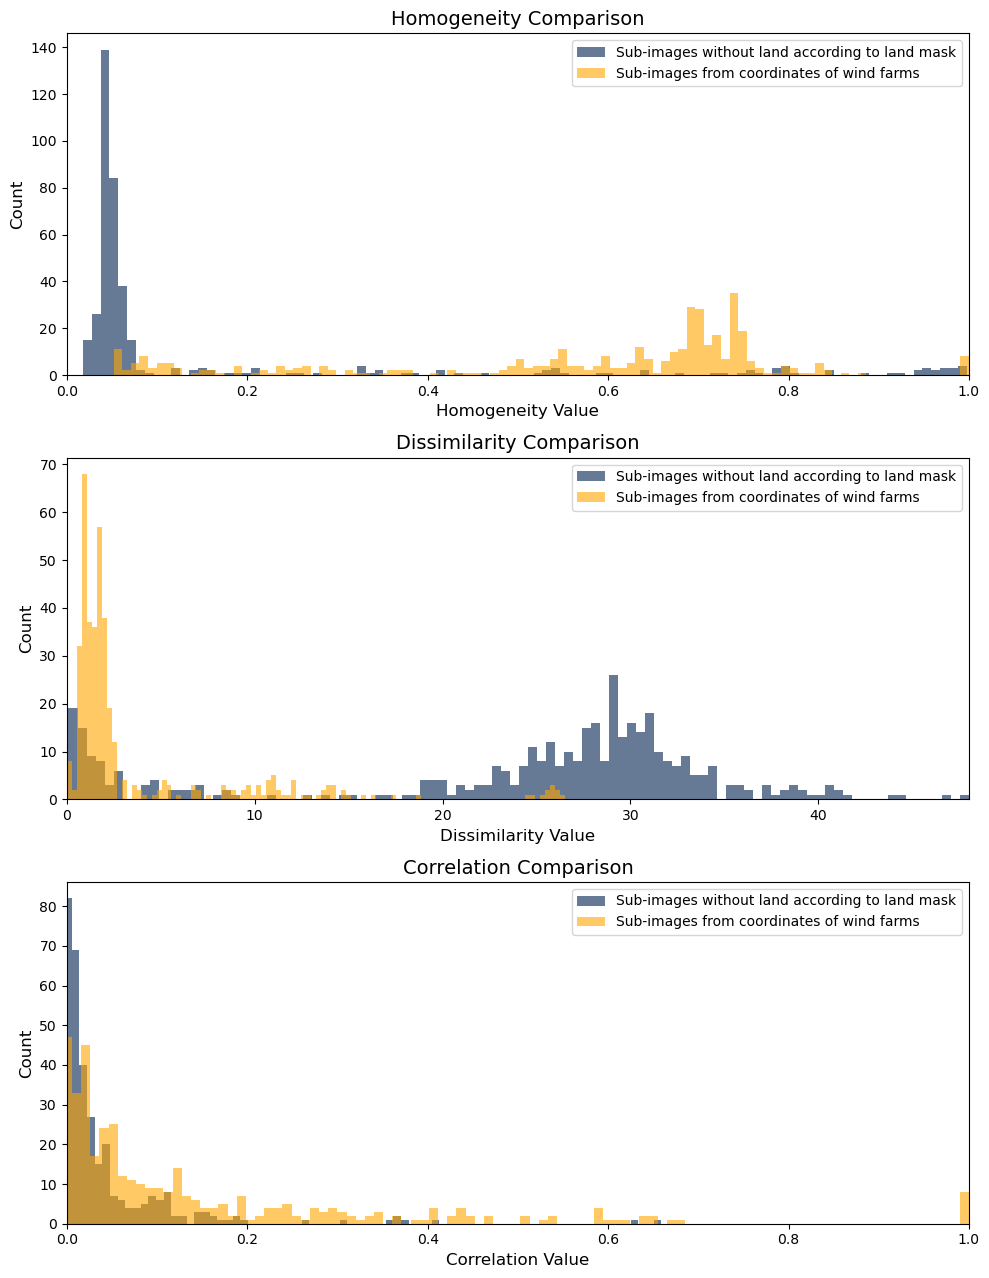

In [62]:
import matplotlib.pyplot as plt

data = [hom_dict, wf_dict]

# --- PLOT SETUP ---
fig, axs = plt.subplots(3, 1, figsize=(10, 14))

# Define x-axis limits
xlims = {
    'hom': (0, 1),
    'dis': (
        min(min(hom_dict['dis']), min(wf_dict['dis'])),
        max(max(hom_dict['dis']), max(wf_dict['dis']))
    ),
    'cor': (0, 1)
}

# Define titles, colors, axis labels, and legend labels
keys = ['hom', 'dis', 'cor']
titles = [
    'Homogeneity Comparison',
    'Dissimilarity Comparison',
    'Correlation Comparison'
]
colors = [plt.get_cmap('cividis')(0), 'orange']
y_label = "Count"
x_labels = [
    "Homogeneity Value",
    "Dissimilarity Value",
    "Correlation Value"
]
legend_labels = [
    "Sub-images without land according to land mask",
    "Sub-images from coordinates of wind farms"
]

# --- PLOT GENERATION ---
for i, ax in enumerate(axs):
    key = keys[i]
    for j, datum in enumerate(data):
        ax.hist(datum[key], bins=100, color=colors[j], alpha=0.6, label=legend_labels[j])
        ax.set_title(titles[i], fontsize=14)
        ax.set_xlim(xlims[key])
        ax.set_xlabel(x_labels[i], fontsize=12)
        ax.set_ylabel(y_label, fontsize=12)
        ax.legend(loc='upper right')

# Enhance overall appearance
#fig.suptitle('Comparison of Homogeneity, Dissimilarity, and Correlation for Two Datasets', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('histogram_hom_filt.pdf')
plt.show()

Train SVC...

In [ ]:
noland_X = np.column_stack((hom_dict['hom'], hom_dict['dis'], hom_dict['cor']))
#filter incorrect values
noland_X = noland_X[noland_X[:, 0] != 1]

wf_X = np.column_stack((wf_dict['hom'], wf_dict['dis'], wf_dict['cor']))
#filter incorrect values
wf_X = wf_X[wf_X[:, 0] != 1]

X, y = (np.concatenate((noland_X, wf_X)),
        np.concatenate((np.zeros_like(noland_X[:, 0]), np.ones_like(wf_X[:, 0]))))
X, y

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
svc = SVC()
svc = svc.fit(X_train, y_train)

In [ ]:
svc.score(X_test, y_test)

...Or load from pickle

In [65]:
with open('./homogenity_svc.pkl', 'rb') as f: svc = pickle.load(f)

Make illustration of missclassified or correctly classified images

/tmp/ipykernel_20982/3429164305.py:7: RuntimeWarning: divide by zero encountered in log10
  transformed_data = np.log10(arr + offset)  # Add a small value to avoid log(0)


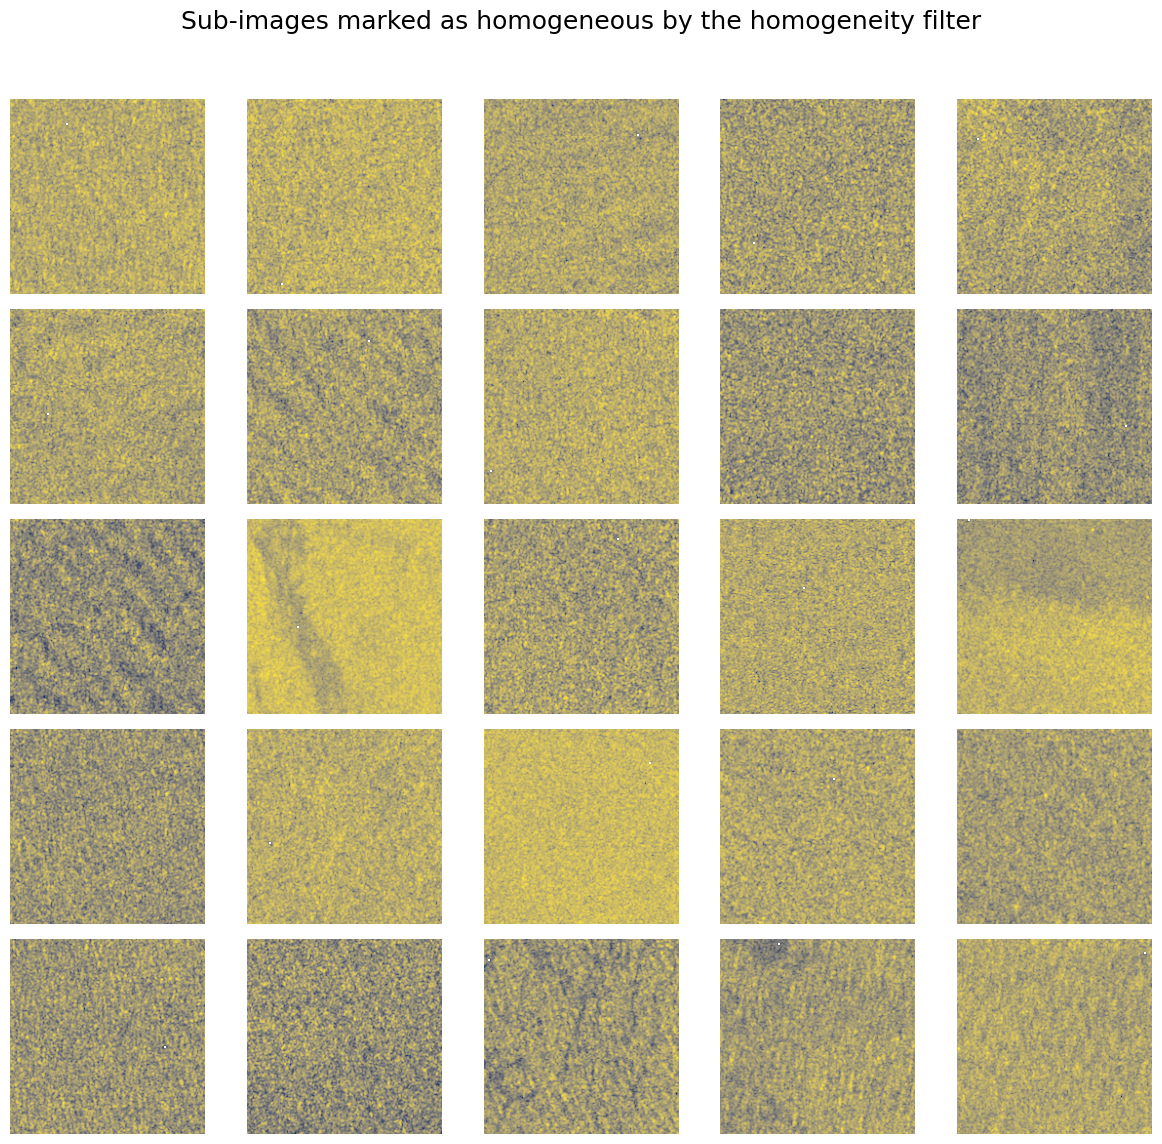

In [161]:
# Define constants
hom_dir = '/data/exjobb/sarssw/sar_dataset'

def apply_log_transform(arr):
    """Apply a logarithmic transformation to the array."""
    offset = np.abs(np.min(arr))
    transformed_data = np.log10(arr + offset)  # Add a small value to avoid log(0)
    return transformed_data

def miss_gen():
    """Generate sigma0 values for misclassified images."""
    x = np.column_stack((hom_dict['hom'], hom_dict['dis'], hom_dict['cor']))

    # Get predictions
    preds = iter(svc.predict(x))
    files = (fn for fn in os.listdir(hom_dir) if fn.endswith('.nc'))
    preds_and_file_name = zip(preds, preds, files)

    for i, (p, _, fn) in enumerate(preds_and_file_name):
        if 'IW' not in fn:
            continue
        # change p == 1 or 0 depending on if you want homogeneous images or not
        if p == 0 and x[i*2, 0] != 1:
            xr_ds = xr.open_dataset(os.path.join(hom_dir, fn))
            sigma0 = xr_ds.isel(pol=0).sigma0
            yield apply_log_transform(sigma0.values) 

missclassified = list(miss_gen())

# Create a 5x5 grid of subplots
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(12, 12))

# Beautify the figure
fig.suptitle('Sub-images marked as homogeneous by the homogeneity filter', fontsize=18)

# Plot each image on the corresponding subplot
for i, ax in enumerate(axes.flat):
    # If there are fewer images than subplots
    if i >= len(missclassified):
        ax.set_axis_off()  # turn off axes for empty subplots
        continue
  
    image = missclassified[i]
    ax.imshow((image), cmap='cividis')


    # Hide axis labels and ticks
    ax.set_axis_off()

# Ensure a tight layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('hom_img_cividis.pdf')
plt.show()
